                                                                                                            gusgraupa

# Assignment 2: More Chinese-language experiments

In this assignment, you will work with the Demo 2.1 - Chinese word segmentation on Chinese word segmentation.  The notebook trains a model that is very successful at determining word boundaries in Chinese text, where word boundaries are binary-encoded on a per-character basis with 1 being the first character of a word and 0 being the second character.  The model uses character embeddings and an LSTM to model the word boundaries.  You will copy and modify Demo 2.1's notebook as below and write up in the notebook Markdown what you did and how well it performed.

This assignment is due at 23:59 on 2021 November 2.  It has 30 points and 15 bonus points.

### Loading the data, padding (based on 2.0)

In [1]:
import sys
import os
import numpy as np
import torch

device = torch.device('cuda:3')

In [2]:
import torch.optim as optim
import matplotlib.pyplot as plt

    We add the <start> as "ñ" and <end> token as "Ö", and get the targets.

In [3]:
def read_chinese_data(inputfilename):
    # the inputfile is in ud format
    # returns a tuple of ([sentence], [collection_labels])
    # collection_labels is 1 for the first characters of the word, and 0 for the others
    
    with open(inputfilename, "r") as inputfile:
        sentences = []
        collection_words = ['ñ']
        collection_labels = []
        for line in inputfile:
            if line[0] == '#':
                continue
            columns = line.split()
            #print(words)
            if columns == []:
                bla = ''.join(collection_words) + 'Ö'
#                 sentences.append(bla)
                sentences.append((bla, [1] + collection_labels))
                collection_words = []
                collection_labels = []
                continue
            collection_words.append(columns[1])
            collection_labels += [1] + ([0] * (len(columns[1]) - 1)) # all but the first words will get a 0 label
            
    return sentences

In [4]:
train_sentences = read_chinese_data('/scratch/lt2316-h20-resources/zh_gsd-ud-train.conllu')

In [5]:
test_sentences = read_chinese_data('/scratch/lt2316-h20-resources/zh_gsd-ud-test.conllu')

In [6]:
def index_chars(sentences):
    # getting an index for each character in the set
    megasentence = ''.join(sentences)
    char_list = set()
    for c in megasentence:
        char_list.add(c) # getting all the characters
    char_list = [0] + list(char_list) # we add a 0
    return char_list, {char_list[x]:x for x in range(len(char_list))}

In [7]:
# we did x[0] for x in train_sentences because the first function returns a tuple
int_index, char_index = index_chars([x[0] for x in train_sentences + test_sentences])

In [11]:
def convert_sentence(sentence, index):
    # so everything is indexed as a number 
    return [index[x] for x in sentence]

In [12]:
def pad_lengths(sentences, max_length, padding=0):
    # we do padding to get it to the right shape so numpy doesna complain
    return [x + ([padding] * (max_length - len(x))) for x in sentences]

In [13]:
def create_dataset(x, device="cpu"):
    converted = [(convert_sentence(x1[0], char_index), x1[1]) for x1 in x]
    X, y = zip(*converted)
    # we need to keep track of the actual lengths of the sentences
    lengths = [len(x2) for x2 in X]
    padded_X = pad_lengths(X, max(lengths)) # padding the sentences
    Xt = torch.LongTensor(padded_X).to(device)
    padded_y = pad_lengths(y, max(lengths), padding=-1) # padding the labels WITH -1!!
    yt = torch.LongTensor(padded_y).to(device)
    lengths_t = torch.LongTensor(lengths).to(device)
    return Xt, lengths_t, yt

In [14]:
# gpu tensor containing input sent, gpu tensor based on lenghts of each sentence, and the -1 padded class labels
train_X_tensor, train_lengths_tensor, train_y_tensor = create_dataset(train_sentences, device)
test_X_tensor, test_lengths_tensor, test_y_tensor = create_dataset(test_sentences, device)

### Packing the sequences for RNN

In [15]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

### Batching (based on 1.0, 1.1, 1.2)

In [16]:
class Batcher:
    def __init__(self, X, lengths, y, device, batch_size=50, max_iter=None):
        self.X = X
        self.lengths = lengths # We need the lengths to efficiently use the padding.
        self.y = y
        self.device = device
        self.batch_size=batch_size
        self.max_iter = max_iter
        self.curr_iter = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.curr_iter == self.max_iter:
            raise StopIteration
        permutation = torch.randperm(self.X.size()[0], device=self.device)
        permX = self.X[permutation]
        permlengths = self.lengths[permutation]
        permy = self.y[permutation]
        splitX = torch.split(permX, self.batch_size)
        splitlengths = torch.split(permlengths, self.batch_size)
        splity = torch.split(permy, self.batch_size)
        
        self.curr_iter += 1
        return zip(splitX, splitlengths, splity)

In [17]:
b = Batcher(train_X_tensor, train_lengths_tensor, train_y_tensor, device, max_iter=100)

### Modeling

In [18]:
import torch.nn as nn

## Part 0 - Character segmentation
From Asad's notebook

    All models are trained with 100 epochs.

In [19]:
class Segmenter0(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super().__init__()
        
        # what's the point of this?
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        
        self.emb = nn.Embedding(self.vocab_size, self.emb_size, 0)
        self.lstm = nn.LSTM(self.emb_size, 150, batch_first=True)
        self.sig1 = nn.Sigmoid()
        self.lin = nn.Linear(150, 2)
        self.softmax = nn.LogSoftmax(2)
        
    def forward(self, x, lengths):
        embs = self.emb(x)
        packed = pack_padded_sequence(embs, lengths.to("cpu"), batch_first=True, enforce_sorted=False)
        output1, _ = self.lstm(packed)
        unpacked, _ = pad_packed_sequence(output1, batch_first=True)
        output2 = self.sig1(unpacked)
        output3 = self.lin(output2)
        return self.softmax(output3)

In [20]:
def train0(X, lengths, y, vocab_size, emb_size, batch_size, epochs, device, model=None):
    b = Batcher(X, lengths, y, device, batch_size=batch_size, max_iter=epochs)
    
#     if not model:
#         m = Segmenter(vocab_size, emb_size).to(device)
#     else:
#         m = model

    m = Segmenter0(vocab_size, emb_size).to(device)
    loss = nn.NLLLoss(ignore_index=-1)
    optimizer = optim.Adam(m.parameters(), lr=0.005)
    epoch = 0
    
    loss_plot = []
    
    for split in b:
        tot_loss = 0
        for batch in split:
            optimizer.zero_grad()
            o = m(batch[0], batch[1])
            l = loss(o.permute(0,2,1), batch[2][:, :max(batch[1])])
            
            loss_plot.append(l)
            
            tot_loss += l
            l.backward()
            optimizer.step()
        print("Total loss in epoch {} is {}.".format(epoch, tot_loss))
        epoch += 1
    
    plt.plot(loss_plot)
    
    return m

Total loss in epoch 0 is 33.425968170166016.
Total loss in epoch 1 is 17.24395179748535.
Total loss in epoch 2 is 11.733686447143555.
Total loss in epoch 3 is 8.110830307006836.
Total loss in epoch 4 is 5.73553991317749.
Total loss in epoch 5 is 4.519376277923584.
Total loss in epoch 6 is 3.4346179962158203.
Total loss in epoch 7 is 2.6329524517059326.
Total loss in epoch 8 is 2.2823922634124756.
Total loss in epoch 9 is 1.9920775890350342.
Total loss in epoch 10 is 1.801770567893982.
Total loss in epoch 11 is 1.6543806791305542.
Total loss in epoch 12 is 1.1278927326202393.
Total loss in epoch 13 is 0.8453371524810791.
Total loss in epoch 14 is 0.6275399923324585.
Total loss in epoch 15 is 0.5688338279724121.
Total loss in epoch 16 is 0.6711459159851074.
Total loss in epoch 17 is 0.9374004006385803.
Total loss in epoch 18 is 1.831060528755188.
Total loss in epoch 19 is 2.030604124069214.
Total loss in epoch 20 is 1.4820802211761475.
Total loss in epoch 21 is 0.7925536036491394.
Total 

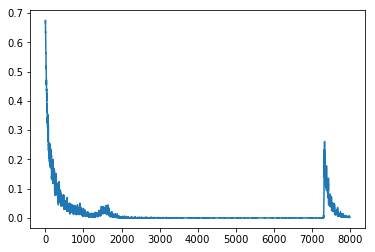

In [44]:
model0 = train0(train_X_tensor, train_lengths_tensor, train_y_tensor, len(int_index), 200, 50, 100, device)

In [47]:
model0.to(device)

Segmenter0(
  (emb): Embedding(3650, 200, padding_idx=0)
  (lstm): LSTM(200, 150, batch_first=True)
  (sig1): Sigmoid()
  (lin): Linear(in_features=150, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=2)
)

## Part 1 - Sentence generation (15 points).

Convert the model in Demo 2.1 into a character-based sentence generator. (Strip out the word segmentation objective.)  The model should, given a start symbol, produce a variety of sentences that terminate with a stop symbol (you will have to add these to the data).  The sentences that it generates should be of reasonable average length compared to the sentences in the training corpus (this needn't be precise). 

    I changed the size of the output of the linear layer to be the size of the vocabulary, to get the probability for each character of the vocabulary.
    I removed the sigmoid function because I was getting many zeros as output.

In [22]:
class Segmenter1(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        
        self.emb = nn.Embedding(self.vocab_size, self.emb_size, 0)
        self.lstm = nn.LSTM(self.emb_size, 150, batch_first=True)
#         self.sig1 = nn.Sigmoid()
        self.lin = nn.Linear(150, self.vocab_size)
        self.softmax = nn.LogSoftmax(2)
        
    def forward(self, x, lengths):
        embs = self.emb(x)
        packed = pack_padded_sequence(embs, lengths.to("cpu"), batch_first=True, enforce_sorted=False)
        output1, _ = self.lstm(packed)
        unpacked, _ = pad_packed_sequence(output1, batch_first=True)
#         output2 = self.sig1(unpacked)
#         output3 = self.lin(output2)
        output3 = self.lin(unpacked)
        output4 = self.softmax(output3)
        
        return output4

    In the loss, we :
    - get rid of the last element of the second dimension of the output of the model, which would be the end token
    - remove the first element of the second dimension of the target of the model, because it is the start token

In [23]:
def train1(X, lengths, y, vocab_size, emb_size, batch_size, epochs, device, model=None):
    b = Batcher(X, lengths, y, device, batch_size=batch_size, max_iter=epochs)
    
#     if not model:
#         m = Segmenter(vocab_size, emb_size).to(device)
#     else:
#         m = model
    m = Segmenter1(vocab_size, emb_size).to(device)
    loss = nn.NLLLoss(ignore_index=-1)
    optimizer = optim.Adam(m.parameters(), lr=0.005)
    epoch = 0
    
    lengths = []
    loss_plot = []
    
    for split in b:
        tot_loss = 0
        for batch in split:
            optimizer.zero_grad()
            
            lengths.append(batch[1])
            
            o = m(batch[0], batch[1]) # batch[1] is the length of the sentences

            l = loss(o[:, :-1, :].permute(0,2,1), batch[0][:, 1:max(batch[1])])
            
            loss_plot.append(l)
            
            tot_loss += l
            l.backward()
            optimizer.step()
        print("Total loss in epoch {} is {}.".format(epoch, tot_loss))
        epoch += 1
        
    plt.plot(loss_plot)
    
#     perplexity  = torch.exp(tot_loss)
    
#     print('perplexity:', perplexity.item())
    
    return m, lengths

Total loss in epoch 0 is 571.1435546875.
Total loss in epoch 1 is 506.4555358886719.
Total loss in epoch 2 is 459.3341369628906.
Total loss in epoch 3 is 415.0297546386719.
Total loss in epoch 4 is 372.6875915527344.
Total loss in epoch 5 is 331.84820556640625.
Total loss in epoch 6 is 292.5474853515625.
Total loss in epoch 7 is 254.5089874267578.
Total loss in epoch 8 is 219.49356079101562.
Total loss in epoch 9 is 187.9837188720703.
Total loss in epoch 10 is 161.32431030273438.
Total loss in epoch 11 is 141.4477996826172.
Total loss in epoch 12 is 126.2373275756836.
Total loss in epoch 13 is 112.74423217773438.
Total loss in epoch 14 is 103.81791687011719.
Total loss in epoch 15 is 98.4115982055664.
Total loss in epoch 16 is 93.44049835205078.
Total loss in epoch 17 is 87.68924713134766.
Total loss in epoch 18 is 82.98928833007812.
Total loss in epoch 19 is 83.2125473022461.
Total loss in epoch 20 is 78.27418518066406.
Total loss in epoch 21 is 75.6357421875.
Total loss in epoch 22 i

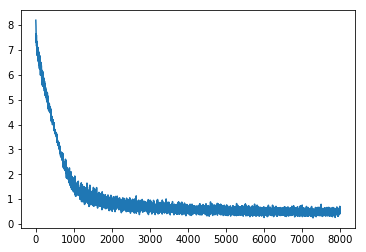

In [45]:
# 200 is emb_size
# 50 is batch_size
# 30 is number of epochs
model1, lengths1 = train1(train_X_tensor, train_lengths_tensor, train_y_tensor, len(int_index), 200, 50, 100, device)

In [48]:
model1.to(device)

Segmenter1(
  (emb): Embedding(3650, 200, padding_idx=0)
  (lstm): LSTM(200, 150, batch_first=True)
  (lin): Linear(in_features=150, out_features=3650, bias=True)
  (softmax): LogSoftmax(dim=2)
)

    The function "generating" creates a sentence given the start symbol (ñ) and a random seed (from possible first characters in the train sentences). The length of the sentence is a random choice from the train_sentences length, or shorter if the model produces a stop symbol (Ö).

In [27]:
# getting list of possible lengths of sentences
l = []
for x in lengths1:
    l.extend(x.tolist())

sentences = train_sentences.extend(test_sentences)
# getting the possible seeds of the sentences
seeds = []
for a, _ in train_sentences:
    seeds.extend(a[1])

In [28]:
import random

def generating(lengths, seeds, char_index, model):
    # the index of the start symbol "ñ" is 2925
    # the index of the end symbol "Ö" is 149
    
    # getting random sentence length
    sent_len = torch.tensor(random.choice(lengths)).to(device).unsqueeze(0)
    sent_len = sent_len.int().to(device)
    
    # getting index of random seed
    seed = random.choice(seeds)
    seed_idx = char_index[seed]

    # generating the original tensor
    original = torch.zeros(sent_len)
    original[0] = char_index['ñ']
    original[1] = seed_idx
    original = original.long().unsqueeze(0).to(device)
    
    # passing it through the model
    for e in range(int(sent_len)-3):
        out = model(original, sent_len)
        m = torch.argmax(out, dim=2)
#         print(m)
        original[0][e+2] = m[0][e+2]
        
        if m[0][e+2] == char_index['Ö']:
            break
    
    original = original.squeeze(0)
    if char_index['Ö'] not in original:
        original[int(sent_len)-1] = char_index['Ö']
    
    inlist = original.tolist()
    text = ''
    for num in inlist:
        char = str(list(char_index.keys())[list(char_index.values()).index(num)])
        text += char
        if char == 'Ö':
            break
        
    return text

In [36]:
generating(l, seeds, char_index, model1)

'ñ據出的力，向進準向軍隊得自出，送會射表將出，手與想，助嚴了毀，任舊政、埔台）。，管確，洛（i直Ö'

In [38]:
generating(l, seeds, char_index, model1)

'ñ國法軍逃，任軍改為。，稱為籤給器的量。。，出Ö'

## Part 2 - Dual objectives (10 points)
Copy the notebook from part 1 and augment the copy by adding back the word segmentation objective, as a second objective with its own loss.  (You could also in theory do Part 1 and Part 2 in reverse, by adding sentence generation with dual objectives first and then stripping out the word segmentation objective; this is equivalent.)  
Note that multiple losses can be combined by simple, possibly weighted addition -- backpropagation works entirely correctly on the combined loss.

    From the original model, I added a second linear layer with an output size as the size of the vocabulary. It returns two tensors, one for the segmentation objective and one for the prediction objective.

In [29]:
class Segmenter(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        
        self.emb = nn.Embedding(self.vocab_size, self.emb_size, 0)
        self.lstm = nn.LSTM(self.emb_size, 150, batch_first=True)
        self.sig1 = nn.Sigmoid()
        self.lin1 = nn.Linear(150, 2)
        self.lin2 = nn.Linear(150, self.vocab_size)
        self.softmax = nn.LogSoftmax(2)
        
    def forward(self, x, lengths):
        embs = self.emb(x)
        packed = pack_padded_sequence(embs, lengths.to("cpu"), batch_first=True, enforce_sorted=False)
        output1, _ = self.lstm(packed)
        unpacked, _ = pad_packed_sequence(output1, batch_first=True)
        output2 = self.sig1(unpacked)
        output3_segm = self.lin1(output2)
        output3_pred = self.lin2(unpacked) # no sigmoid for text prediction
        
        return (self.softmax(output3_segm), self.softmax(output3_pred))
        

    We calculate two losses, one for each objective. 

In [30]:
def train(X, lengths, y, vocab_size, emb_size, batch_size, epochs, device, model=None):
    b = Batcher(X, lengths, y, device, batch_size=batch_size, max_iter=epochs)
    
#     if not model:
#         m = Segmenter(vocab_size, emb_size).to(device)
#     else:
#         m = model
    
    m = Segmenter(vocab_size, emb_size).to(device)
    loss = nn.NLLLoss(ignore_index=-1)
    optimizer = optim.Adam(m.parameters(), lr=0.005)
    epoch = 0
    
    loss_plot1 = []
    loss_plot2 = []
    loss_summ = []
    
    lengths = []
    
    for split in b:
        tot_loss = 0
        for batch in split:
            optimizer.zero_grad()
            
            lengths.append(batch[1])
            
            o_segm, o_pred = m(batch[0], batch[1]) # batch[1] is the length of the sentences

            l1 = loss(o_segm.permute(0,2,1), batch[2][:, :max(batch[1])])
            l2 = loss(o_pred[:, :-1, :].permute(0,2,1), batch[0][:, 1:max(batch[1])])
            
            loss_plot1.append(l1)
            loss_plot2.append(l2)
            
            superl = l1 + l2
            
            loss_summ.append(superl)
            
            tot_loss += superl
            
            superl.backward()
            
#             l1.backward(retain_graph=True)
#             l2.backward()
            
            optimizer.step()
        print("Total loss in epoch {} is {}.".format(epoch, tot_loss))
        epoch += 1
    
    plt.plot(loss_plot1, label = 'Segmentation loss')
    plt.plot(loss_plot2, label = 'Prediction loss')
    plt.plot(loss_summ, label = 'Total loss')
    plt.legend(loc="upper right")
    
#     perplexity  = torch.exp(tot_loss)
    
#     print('perplexity:', perplexity.item())
    
    return m, lengths

Total loss in epoch 0 is 613.0823364257812.
Total loss in epoch 1 is 531.5040893554688.
Total loss in epoch 2 is 476.08526611328125.
Total loss in epoch 3 is 429.22210693359375.
Total loss in epoch 4 is 385.42529296875.
Total loss in epoch 5 is 344.59014892578125.
Total loss in epoch 6 is 304.8947448730469.
Total loss in epoch 7 is 267.8619384765625.
Total loss in epoch 8 is 232.54722595214844.
Total loss in epoch 9 is 200.01365661621094.
Total loss in epoch 10 is 176.8213653564453.
Total loss in epoch 11 is 156.35662841796875.
Total loss in epoch 12 is 139.55943298339844.
Total loss in epoch 13 is 129.03533935546875.
Total loss in epoch 14 is 121.10475158691406.
Total loss in epoch 15 is 114.87969207763672.
Total loss in epoch 16 is 108.7334976196289.
Total loss in epoch 17 is 104.73020935058594.
Total loss in epoch 18 is 101.44131469726562.
Total loss in epoch 19 is 97.85631561279297.
Total loss in epoch 20 is 94.05367279052734.
Total loss in epoch 21 is 91.00130462646484.
Total loss

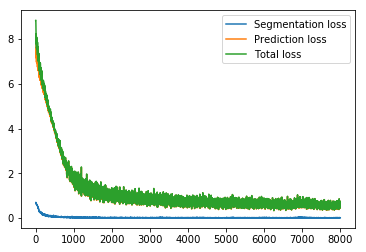

In [46]:
# 200 is emb_size
# 50 is batch_size
# 30 is number of epochs
model, lengths = train(train_X_tensor, train_lengths_tensor, train_y_tensor, len(int_index), 200, 50, 100, device)

    The total loss and the prediction loss are almost the same, because the segmentation loss is very low.

In [49]:
model.to(device)

Segmenter(
  (emb): Embedding(3650, 200, padding_idx=0)
  (lstm): LSTM(200, 150, batch_first=True)
  (sig1): Sigmoid()
  (lin1): Linear(in_features=150, out_features=2, bias=True)
  (lin2): Linear(in_features=150, out_features=3650, bias=True)
  (softmax): LogSoftmax(dim=2)
)

## Part 3 - Analysis (5 points)
You now have three models.  The original word segmentation model, a sentence generation model, and a dual sentence-generation/word segmentation model. 

Compare the performance on the test data of the original word segmentation model between the original objective and the dual objective model.  
- In how many iterations do the models converge?  
- What are their final F1 and accuracy scores once they've converged? 
- Are they any different?  If so, why?

Make the same comparison between the sentence generation model and the dual-objective model, except the performance measure is the per-word perplexity on the text (_test?_) corpus.

### Evaluation - word segmentation

    From Asad's word segmentation model (model0):

In [50]:
model0.eval()
model.eval()

Segmenter(
  (emb): Embedding(3650, 200, padding_idx=0)
  (lstm): LSTM(200, 150, batch_first=True)
  (sig1): Sigmoid()
  (lin1): Linear(in_features=150, out_features=2, bias=True)
  (lin2): Linear(in_features=150, out_features=3650, bias=True)
  (softmax): LogSoftmax(dim=2)
)

In [51]:
with torch.no_grad():
    rawpredictions0 = model0(test_X_tensor, test_lengths_tensor)
predictions0 = torch.argmax(rawpredictions0, 2)

collectpreds0 = []
collecty0 = []

for i in range(test_X_tensor.size(0)):
    collectpreds0.append(predictions0[i][:test_lengths_tensor[i]])
    collecty0.append(test_y_tensor[i][:test_lengths_tensor[i]])
    
allpreds0 = torch.cat(collectpreds0).float()
classes0 = torch.cat(collecty0).float()

In [52]:
tp0 = sum(classes0 * allpreds0)
fp0 = sum(classes0 * (~allpreds0.bool()).float())
tn0 = sum((~classes0.bool()).float() * (~allpreds0.bool()).float())
fn0 = sum((~classes0.bool()).float() * allpreds0)

In [53]:
accuracy0 = (tp0 + tn0) / (tp0 + fp0 + tn0 + fn0)
accuracy0

tensor(0.9393, device='cuda:3')

In [54]:
recall0 = tp0 / (tp0 + fn0)
recall0

tensor(0.9506, device='cuda:3')

In [55]:
precision0 = tp0 / (tp0 + fp0)
precision0

tensor(0.9539, device='cuda:3')

In [56]:
f1_0 = (2 * recall0 * precision0) / (recall0 + precision0)
f1_0

tensor(0.9522, device='cuda:3')

    From the dual model:

In [57]:
with torch.no_grad():
    rawpredictions, bla = model(test_X_tensor, test_lengths_tensor)
predictions = torch.argmax(rawpredictions, 2)
collectpreds = []
collecty = []
for i in range(test_X_tensor.size(0)):
    collectpreds.append(predictions[i][:test_lengths_tensor[i]])
    collecty.append(test_y_tensor[i][:test_lengths_tensor[i]])
allpreds = torch.cat(collectpreds).float()
classes = torch.cat(collecty).float()

In [58]:
tp = sum(classes * allpreds)
fp = sum(classes * (~allpreds.bool()).float())
tn = sum((~classes.bool()).float() * (~allpreds.bool()).float())
fn = sum((~classes.bool()).float() * allpreds)

In [59]:
accuracy = (tp + tn) / (tp + fp + tn + fn)
accuracy

tensor(0.9320, device='cuda:3')

In [60]:
recall = tp / (tp + fn)
recall

tensor(0.9419, device='cuda:3')

In [61]:
precision = tp / (tp + fp)
precision

tensor(0.9517, device='cuda:3')

In [62]:
f1 = (2 * recall * precision) / (recall + precision)
f1

tensor(0.9468, device='cuda:3')

    Asad's word segmentation model seems to converge at epoch number 40, while the model for part 1 converges at epoch number 80, since the loss does not seem to get that much lower. The dual model converges around epoch 80 as well.

| Model | Accuracy | F1score |
| --- | --- | --- |
| Asad's | 0.9393 | 0.9522|
| Dual | 0.9320 | 0.9468|

    The f1 score for Asad's word segmentation model is 95,22% and the f1 score for the dual model is 94,68% when checking the segmentation objective. The accuracy for the first model is 93.93% and 93.2% in the second one.
    The dual model's f1 is 0,54% lower, and the accuracy, 0.73% lower. They are quite similar, probably because both models have the same layers and hyperparameters.

#### Evaluation - text generation

In [39]:
def perplexity_time_simple(X, lengths, y, vocab_size, emb_size, batch_size, epochs, device, model):
    loss = nn.CrossEntropyLoss()
    b = Batcher(X, lengths, y, device, batch_size=batch_size, max_iter=epochs)
    for split in b:
            tot_loss = 0
            for batch in split:
                out = model(batch[0], batch[1])
                l = loss(out[:, :-1, :].permute(0,2,1), batch[0][:, 1:max(batch[1])])
                tot_loss += l
    
    perplexity  = torch.exp(tot_loss/50)
    
    print('Total perplexity:', perplexity.item())
    return perplexity.item()

In [42]:
perplexity_time_simple(test_X_tensor, test_lengths_tensor, test_y_tensor, len(int_index), 200, 50, 30, device, model1)

Total perplexity: 1.64597749710083


1.64597749710083

In [37]:
def perplexity_time_dual(X, lengths, y, vocab_size, emb_size, batch_size, epochs, device, model):
    loss = nn.CrossEntropyLoss()
    b = Batcher(X, lengths, y, device, batch_size=batch_size, max_iter=epochs)
    for split in b:
            tot_loss = 0
            for batch in split:
                _, out = model(batch[0], batch[1])
                l = loss(out[:, :-1, :].permute(0,2,1), batch[0][:, 1:max(batch[1])])
                tot_loss += l
    
    perplexity  = torch.exp(tot_loss/50)
    
    print('Total perplexity:', perplexity.item())
    return perplexity.item()

In [40]:
# train_X_tensor, train_lengths_tensor, train_y_tensor, len(int_index), 200, 50, 30, "cuda:1"
perplexity_time_dual(test_X_tensor, test_lengths_tensor, test_y_tensor, len(int_index), 200, 50, 30, device, model)

Total perplexity: 1.6071158647537231


1.6071158647537231

    The perplexity for the language generation model is slightly higher than the perplexity of the dual objective model: the first one gets 1.646 and the second one, 1.607. This means that the dual objective model performs somwehat better, which is suprising, given the results (accuracy and f1 score) for the character detection part of the model.